In [1]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import imutils
import matplotlib.pyplot as plt
import tensorflow as tf

### Data Preprocessing

#### Cropping the images to remove background

In [2]:
def crop_img(img):
	"""
	Finds the extreme points on the image and crops the rectangular out of them
	"""
	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	gray = cv2.GaussianBlur(gray, (3, 3), 0)

	# threshold the image, then perform a series of erosions +
	# dilations to remove any small regions of noise
	thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
	thresh = cv2.erode(thresh, None, iterations=2)
	thresh = cv2.dilate(thresh, None, iterations=2)

	# find contours in thresholded image, then grab the largest one
	cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)

	# find the extreme points
	extLeft = tuple(c[c[:, :, 0].argmin()][0])
	extRight = tuple(c[c[:, :, 0].argmax()][0])
	extTop = tuple(c[c[:, :, 1].argmin()][0])
	extBot = tuple(c[c[:, :, 1].argmax()][0])
	ADD_PIXELS = 0
	new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
	
	return new_img

##### Creating a cropped folder in which cropped training and testing images are stored

In [3]:
if __name__ == "__main__":
	training = "Dataset/Trainingbrain"
	testing = "Dataset/Testingbrain"
	training_dir = os.listdir(training)
	testing_dir = os.listdir(testing)
	IMG_SIZE = 256
	
	for dir in training_dir:
		save_path = 'Dataset/cropped/Training/'+ dir
		path = os.path.join(training,dir)
		image_dir = os.listdir(path)
		for img in image_dir:
			image = cv2.imread(os.path.join(path,img))
			new_img = crop_img(image)
			new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
			if not os.path.exists(save_path):
				os.makedirs(save_path)
			cv2.imwrite(save_path+'/'+img, new_img)
	
	for dir in testing_dir:
		save_path = 'Dataset/cropped/Testing/'+ dir
		path = os.path.join(testing,dir)
		image_dir = os.listdir(path)
		for img in image_dir:
			image = cv2.imread(os.path.join(path,img))
			new_img = crop_img(image)
			new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
			if not os.path.exists(save_path):
				os.makedirs(save_path)
			cv2.imwrite(save_path+'/'+img, new_img)


	

In [4]:
training_dir

['glioma', 'meningioma', 'notumor', 'pituitary']

##### Cropped images Demo 

In [5]:
img = cv2.imread('./Dataset/Trainingbrain/meningioma/Tr-me_0476.jpg')
img = cv2.resize(
            img,
            dsize=(224,224),
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

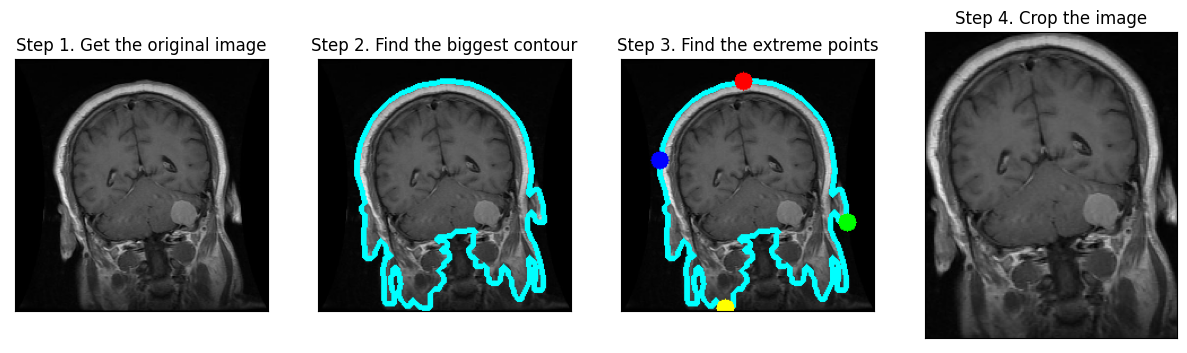

In [6]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

##### Creating X and Y variables

In [7]:
X_train = []
y_train = []
X_test = []
y_test = []
image_size = 200
labels = ['glioma','meningioma','notumor','pituitary'] 
for i in labels:
    folderpath = os.path.join('./Dataset/Cropped/Training',i)
    for j in os.listdir(folderpath):
        image = cv2.imread(os.path.join(folderpath,j),0) #load images in gray
        image = cv2.bilateralFilter(image,2,50,50) # remove noise image
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image.
        image = cv2.resize(image, (image_size, image_size)) # resize images
        X_train.append(image)
        y_train.append(labels.index(i))
        
for i in labels:
    folderpath = os.path.join('./Dataset/Cropped/Testing',i)
    for j in os.listdir(folderpath):
        image = cv2.imread(os.path.join(folderpath,j),0) #load images in gray
        image = cv2.bilateralFilter(image,2,50,50) # remove noise image
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image.
        image = cv2.resize(image, (image_size, image_size)) # resize images
        X_test.append(image)
        y_test.append(labels.index(i))

X_train = np.array(X_train) / 255.0 # normalize Images into range 0 to 1.
X_test = np.array(X_test) / 255.0

print(X_train.shape)
print(X_test.shape)
        

(5712, 200, 200, 3)
(1311, 200, 200, 3)


(5712, 200, 200, 3) signifies the dimensions of the training dataset. 

- **5712**: This denotes the number of individual samples or images in the training set. Each sample serves as an instance for training the machine learning model.

- **200**: This indicates that each image has a width of 200 pixels. Resizing all images to this uniform width ensures compatibility and consistency when feeding them into a model.

- **200**: Similarly, this signifies the height of each image, also being 200 pixels. Having a consistent spatial size (width and height) is crucial for most machine learning and deep learning models.

- **3**: This represents the three color channels (Red, Green, Blue, or RGB) for each image. Despite initially reading the images in grayscale, the application of `cv2.applyColorMap` seems to have transformed them into color-mapped images with three channels, which is typical for colored images processed by models, especially convolutional neural networks (CNNs) that are designed to handle color information.

In summary, `X_train` is a four-dimensional array (or tensor) containing 5712 samples, each being a 200x200 pixel RGB image, well-suited for direct input into deep learning models for training.

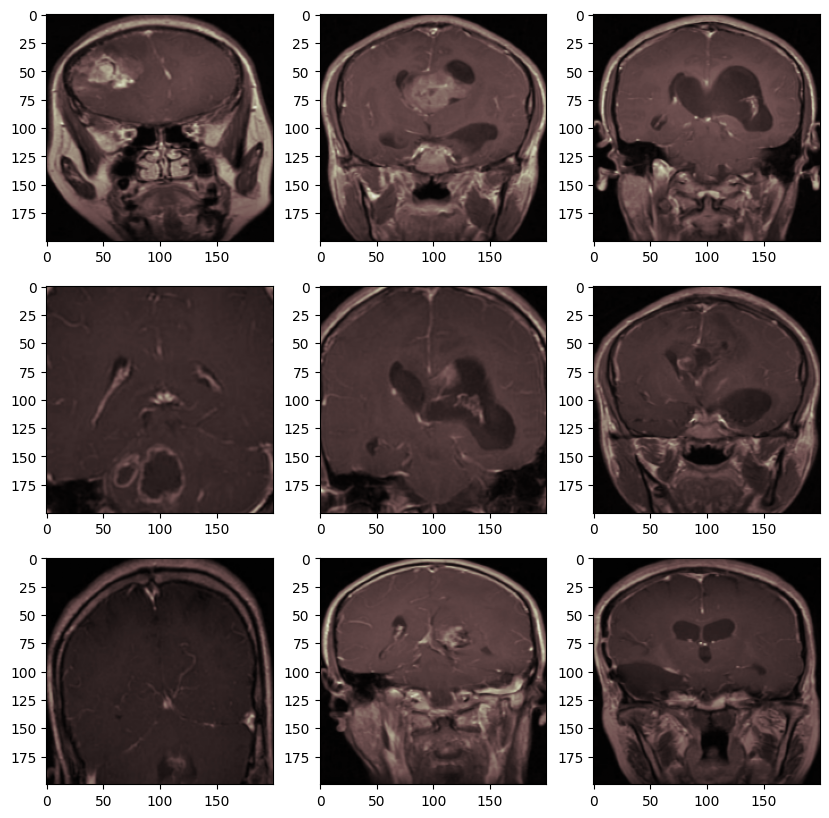

In [8]:
images = [X_train[i] for i in range(9)]
fig, axes = plt.subplots(3, 3, figsize = (10, 10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
#plt.tight_layout()
plt.show()

### Train test split

In [9]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [10]:
X_train, y_train = shuffle(X_train,y_train, random_state=42) 

In [11]:
#One Hot Encoding on the labels
y_train = tf.keras.utils.to_categorical(y_train) 
y_test = tf.keras.utils.to_categorical(y_test)

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42) #Dividing the dataset into Training and Validation sets.
print(X_val.shape)
print(X_train.shape)
print(X_test.shape)

(1143, 200, 200, 3)
(4569, 200, 200, 3)
(1311, 200, 200, 3)


### Image Augmentation

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Dropout,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [14]:
# ImageDataGenerator transforms each image in the batch by a series of random translations, rotations, etc.
datagen = ImageDataGenerator(
     rotation_range=10,                        
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

# After you have created and configured your ImageDataGenerator, you must fit it on your data.
datagen.fit(X_train)

### Model Training

In [15]:
from tensorflow.keras.applications.vgg19 import VGG19
IMG_SIZE=(200,200)
base_model = VGG19(
    include_top=False,
    input_shape=IMG_SIZE + (3,),
    weights='imagenet')

for layer in base_model.layers:
    layer.trainable = True

In [16]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

In [17]:
# Customized layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.4)(x)
predict = Dense(4,activation='softmax')(x)

# create a model object
model = Model(inputs = base_model.input,outputs = predict)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

In [18]:
#compile our model.
adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['accuracy'])

Optimizer Definition:
An instance of the Adam optimizer is defined here. Adam is a widely-used optimization algorithm in deep learning, known for its efficiency and computational effectiveness. It combines the benefits of both momentum and RMSProp, and adaptively adjusts the learning rate during training. By setting learning_rate=0.0001, a relatively small learning rate is specified, which can help the model converge more stably, albeit potentially requiring more epochs to reach optimal performance.

Model Compilation:
optimizer=adam: Specifies that the previously defined Adam optimizer should be used to perform backpropagation and weight updates during training.
loss='categorical_crossentropy': Chooses "categorical crossentropy" as the loss function. This is a commonly used loss function for multi-class classification problems, particularly when the output layer uses a softmax activation. Categorical crossentropy measures the difference between two probability distributions – in this case, the true distribution of labels versus the predicted probabilities by the model.

In [19]:
train_len = len(X_train)
val_len = len(X_val)
print("-----------Training Data length-----------------")
print(train_len)

print("-----------Validation Data length-----------------")
print(val_len)

-----------Training Data length-----------------
4569
-----------Validation Data length-----------------
1143


In [20]:
hist = model.fit(datagen.flow(X_train, y_train, batch_size=32),validation_data = (X_val,y_val),epochs =25,verbose=1)

Epoch 1/25
143/143 [==============================] - 1064s 7s/step - loss: 1.2754 - accuracy: 0.3701 - val_loss: 1.1630 - val_accuracy: 0.3780
Epoch 2/25
143/143 [==============================] - 1062s 7s/step - loss: 1.0802 - accuracy: 0.4662 - val_loss: 0.9479 - val_accuracy: 0.5652
Epoch 3/25
143/143 [==============================] - 1045s 7s/step - loss: 0.9379 - accuracy: 0.5721 - val_loss: 0.9779 - val_accuracy: 0.6465
Epoch 4/25
143/143 [==============================] - 1069s 7s/step - loss: 0.7374 - accuracy: 0.7065 - val_loss: 0.7244 - val_accuracy: 0.7165
Epoch 5/25
143/143 [==============================] - 1072s 7s/step - loss: 0.5598 - accuracy: 0.7884 - val_loss: 0.4859 - val_accuracy: 0.8040
Epoch 6/25
143/143 [==============================] - 1049s 7s/step - loss: 0.4484 - accuracy: 0.8339 - val_loss: 0.4347 - val_accuracy: 0.8346
Epoch 7/25
143/143 [==============================] - 1051s 7s/step - loss: 0.4171 - accuracy: 0.8534 - val_loss: 0.4675 - val_accuracy:

### Plotting output results

In [21]:
#Plotting the results
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

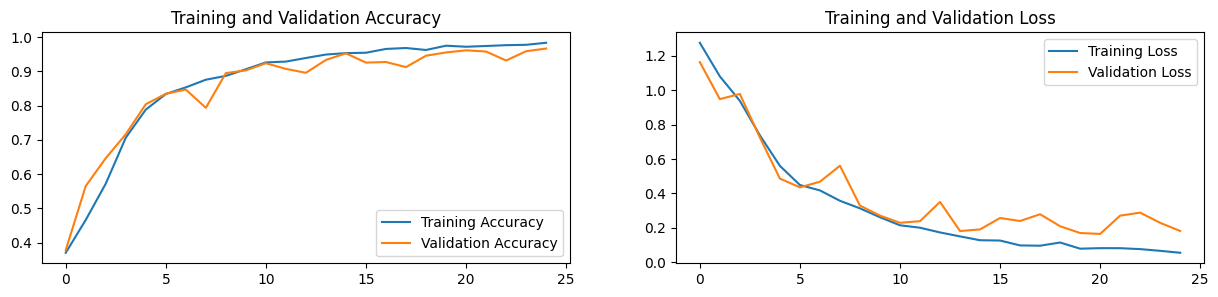

In [22]:
plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
plt.plot(acc,label='Training Accuracy')
plt.plot(val_acc,label='Validation Accuracy')
plt.legend(loc= "lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(loss,label='Training Loss')
plt.plot(val_loss,label='Validation Loss')
plt.legend(loc= "upper right")
plt.title("Training and Validation Loss")
plt.savefig('VGGAccLoss.pdf', format='pdf')

In [23]:
from tensorflow.keras.models import load_model

In [24]:
#Saving the model
model.save('bestvgg19-2.h5')

### Validation on Test set

In [25]:
loss,acc = model.evaluate(X_test,y_test)

41/41 [==============================] - 73s 2s/step - loss: 0.1295 - accuracy: 0.9718


##### Classification Report

In [26]:
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
predicted_classes = np.argmax(model.predict(X_test), axis = 1)
print(classification_report(np.argmax(y_test,axis=1), predicted_classes,target_names=['glioma','meningioma','no_tumor','pituitary']))

              precision    recall  f1-score   support

      glioma       0.97      0.94      0.95       300
  meningioma       0.93      0.99      0.96       306
    no_tumor       1.00      0.99      0.99       405
   pituitary       0.99      0.97      0.98       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



##### Confusion Matrix

164/164 [==============================] - 77s 469ms/step


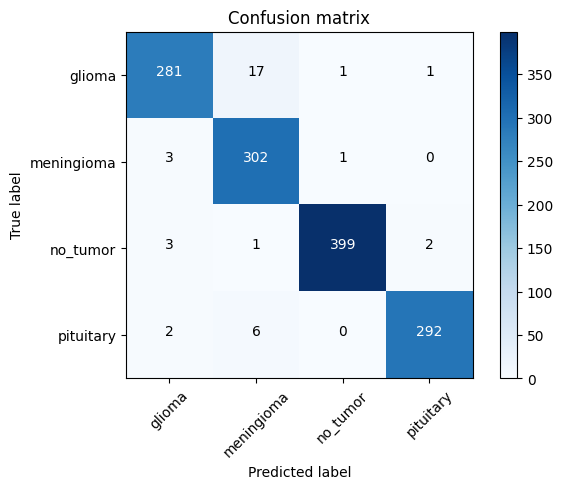

In [27]:
import itertools
pred_Y = model.predict(X_test, batch_size = 8, verbose = True)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    target_names=['glioma','meningioma','no_tumor','pituitary']

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_test, batch_size=8)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(pred_Y,axis = 1) 
# Convert validation observations to one hot vectors
# compute the confusion matrix
rounded_labels=np.argmax(y_test, axis=1)
confusion_mtx = confusion_matrix(rounded_labels, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(4)) 
plt.savefig('VGGCM.pdf', format='pdf')

#### Plotting sample predictions

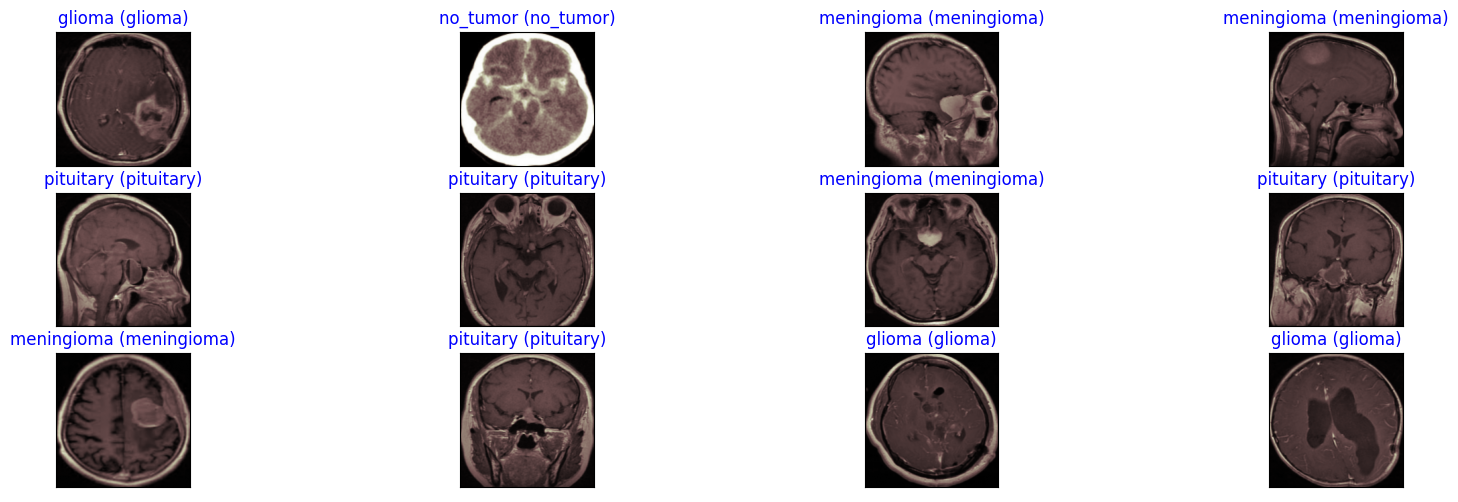

In [28]:
y_hat = model.predict(X_test)

# define text labels 
target_labels = ['glioma','meningioma','no_tumor','pituitary']

# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(X_test.shape[0], size=12, replace=False)):
    ax = fig.add_subplot(4,4, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]),
                 color=("blue" if pred_idx == true_idx else "orange"))

In [29]:
model = load_model('bestvgg19-2.h5')

In [30]:
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
#from scipy import interp
from itertools import cycle
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

82/82 [==============================] - 74s 903ms/step


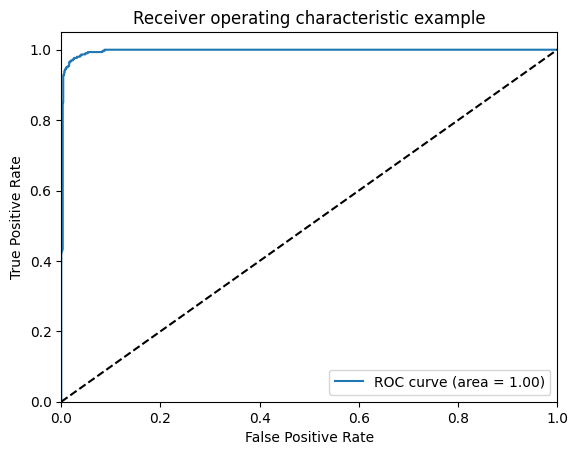

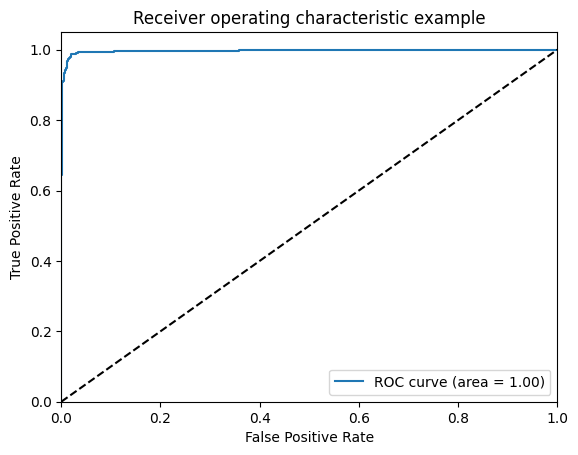

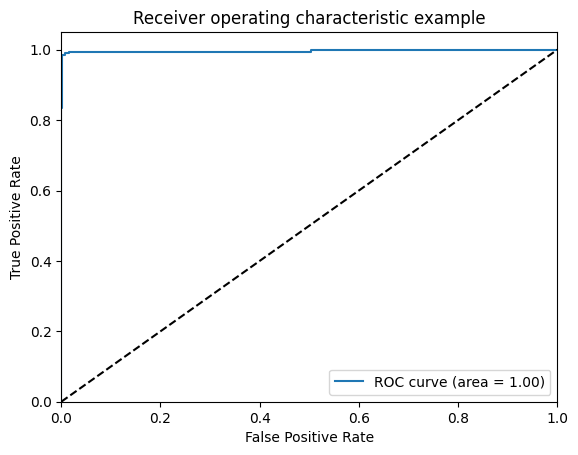

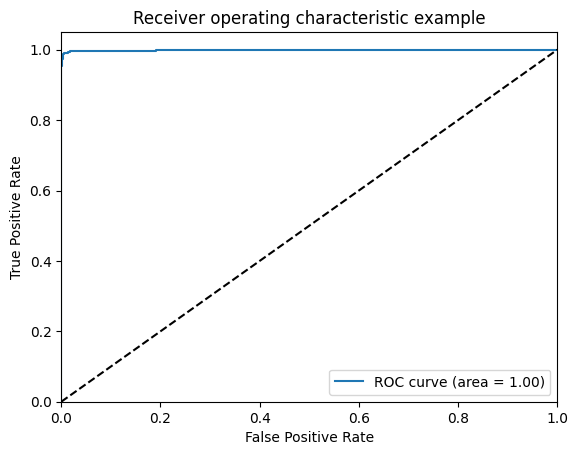

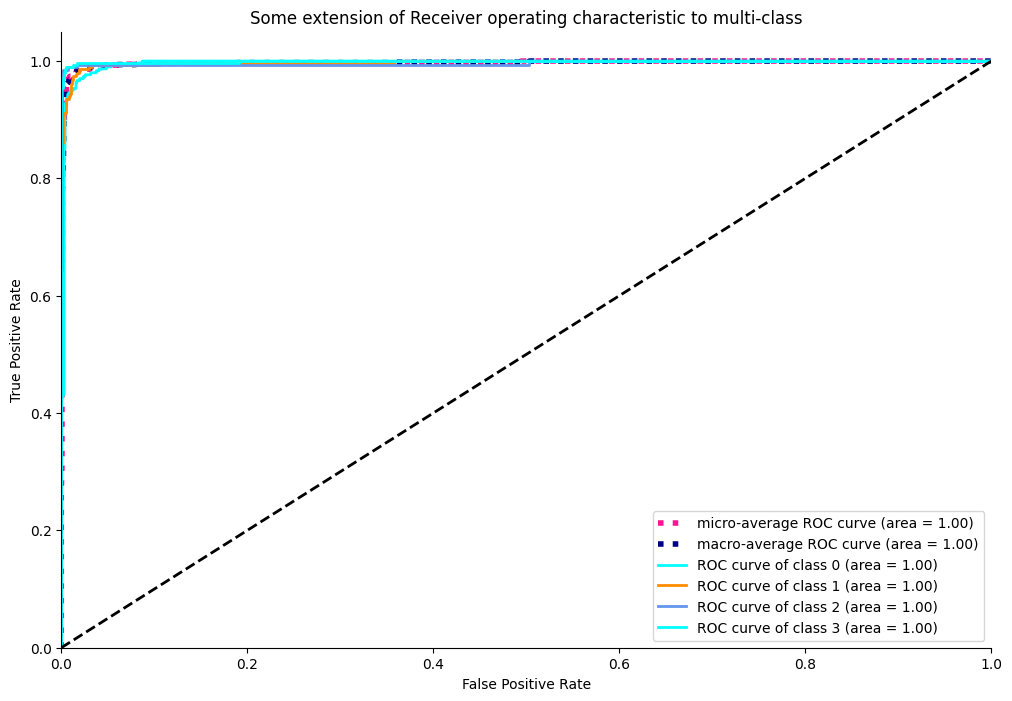

In [31]:
y_test = np.array(y_test)

n_classes = 4

pred_Y = model.predict(X_test, batch_size = 16, verbose = True)
# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred_Y[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_Y.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
fig = plt.figure(figsize=(12, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
sns.despine()
plt.show()

Count Prediction time

In [32]:
from tensorflow.keras.models import load_model
model = load_model('bestvgg19.h5')

In [33]:
import os
import time
from tensorflow.keras.preprocessing import image
import numpy as np

# Define the labels
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# Define the directories
directories = {
    'glioma': './Dataset/Testingprediction/glioma',
    'meningioma': './Dataset/Testingprediction/meningioma',
    'notumor': './Dataset/Testingprediction/notumor',
    'pituitary': './Dataset/Testingprediction/pituitary'
}

# Function to measure prediction time for images in a directory
def measure_prediction_time(model, directory):
    times = []
    for img_name in os.listdir(directory):
        img_path = os.path.join(directory, img_name)
        img = image.load_img(img_path, target_size=(200, 200))
        x = image.img_to_array(img)
        x = x / 255.0
        x = np.expand_dims(x, axis=0)
        
        start_time = time.time()
        predict_image = model.predict(x)
        end_time = time.time()
        
        prediction_time = end_time - start_time
        times.append(prediction_time)
    
    return times

# Dictionary to store times for each category
prediction_times = {}

# Measure prediction times for each category
for label, directory in directories.items():
    times = measure_prediction_time(model, directory)
    prediction_times[label] = times
    avg_time = np.mean(times)
    max_time = np.max(times)
    min_time = np.min(times)
    print(f"{label}: Average time = {avg_time:.4f} seconds, Max time = {max_time:.4f} seconds, Min time = {min_time:.4f} seconds")

# If you want to print the overall results for all categories
overall_times = [time for times in prediction_times.values() for time in times]
avg_time = np.mean(overall_times)
max_time = np.max(overall_times)
min_time = np.min(overall_times)
print(f"Overall: Average time = {avg_time:.4f} seconds, Max time = {max_time:.4f} seconds, Min time = {min_time:.4f} seconds")


glioma: Average time = 0.1269 seconds, Max time = 0.1948 seconds, Min time = 0.0939 seconds
meningioma: Average time = 0.1225 seconds, Max time = 0.1692 seconds, Min time = 0.0940 seconds
notumor: Average time = 0.1290 seconds, Max time = 0.1749 seconds, Min time = 0.0950 seconds
pituitary: Average time = 0.1420 seconds, Max time = 0.3330 seconds, Min time = 0.0952 seconds
Overall: Average time = 0.1301 seconds, Max time = 0.3330 seconds, Min time = 0.0939 seconds


In [34]:
import os
import time
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image

# Define the labels
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# Define the directories
directories = {
    'glioma': './Dataset/Testingprediction/glioma',
    'meningioma': './Dataset/Testingprediction/meningioma',
    'notumor': './Dataset/Testingprediction/notumor',
    'pituitary': './Dataset/Testingprediction/pituitary'
}

# Function to measure prediction time for images in a directory
def measure_prediction_time(model, directory):
    times = []
    for img_name in os.listdir(directory):
        img_path = os.path.join(directory, img_name)
        img = image.load_img(img_path, target_size=(200, 200))
        x = image.img_to_array(img)
        x = x / 255.0
        x = np.expand_dims(x, axis=0)
        
        start_time = time.time()
        predict_image = model.predict(x)
        end_time = time.time()
        
        prediction_time = end_time - start_time
        times.append(prediction_time)
    
    return times

# Dictionary to store times for each category
prediction_times = {}

# Measure prediction times for each category
for label, directory in directories.items():
    times = measure_prediction_time(model, directory)
    prediction_times[label] = times

# Create a DataFrame to organize the results
results = {
    'Category': [],
    'Average Time (s)': [],
    'Max Time (s)': [],
    'Min Time (s)': []
}

for label, times in prediction_times.items():
    avg_time = np.mean(times)
    max_time = np.max(times)
    min_time = np.min(times)
    results['Category'].append(label)
    results['Average Time (s)'].append(avg_time)
    results['Max Time (s)'].append(max_time)
    results['Min Time (s)'].append(min_time)

# Add overall statistics
overall_times = [time for times in prediction_times.values() for time in times]
avg_time = np.mean(overall_times)
max_time = np.max(overall_times)
min_time = np.min(overall_times)
results['Category'].append('Overall')
results['Average Time (s)'].append(avg_time)
results['Max Time (s)'].append(max_time)
results['Min Time (s)'].append(min_time)

# Create a DataFrame and print it
df = pd.DataFrame(results)
print(df)


     Category  Average Time (s)  Max Time (s)  Min Time (s)
0      glioma          0.127610      0.157071      0.112000
1  meningioma          0.111907      0.136000      0.098740
2     notumor          0.105120      0.125139      0.093982
3   pituitary          0.102257      0.123001      0.092993
4     Overall          0.111724      0.157071      0.092993
